In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import re

import nltk
import nltk.data
from string import punctuation 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [2]:
dfn=pd.read_csv('../data/raw/go_emotions_dataset.csv')
dfe = pd.read_pickle('../data/raw/emotions_training.pkl')


In [3]:
dfn=dfn[['text','neutral']]

In [4]:
dfn=dfn[dfn.neutral==1]

In [5]:
mapp={1:'neutral'}
dfn['neutral']=dfn['neutral'].map(mapp)
dfn=dfn.rename(columns={'neutral':'emotions'})

dfn

,text,emotions
2,"You do right, if you don't care then fuck 'em!",neutral
4,"[NAME] was nowhere near them, he was by the Fa...",neutral
10,"I have, and now that you mention it, I think t...",neutral
12,BUT IT'S HER TURN! /s,neutral
14,Build a wall? /jk,neutral
...,...,...
211209,OH YEAH!!,neutral
211210,Let me give you a hint: THEY PLAY IN BOSTON!!!,neutral
211211,to google cuz I wasn't alive back then but dam...,neutral
211213,"Wow, she headlines two shows now",neutral


In [42]:
dfn['text'][12]

"BUT IT'S HER TURN! /s"

In [6]:
dfe

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [7]:
df=pd.concat([dfe,dfn], ignore_index=True)
df=df.reset_index()
df


,index,text,emotions
0,0,i feel awful about it too because it s my job ...,sadness
1,1,im alone i feel awful,sadness
2,2,ive probably mentioned this before but i reall...,joy
3,3,i was feeling a little low few days back,sadness
4,4,i beleive that i am much more sensitive to oth...,love
...,...,...,...
472102,472102,OH YEAH!!,neutral
472103,472103,Let me give you a hint: THEY PLAY IN BOSTON!!!,neutral
472104,472104,to google cuz I wasn't alive back then but dam...,neutral
472105,472105,"Wow, she headlines two shows now",neutral


In [8]:
df['cleaned_text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


In [9]:
def text_cleaning(text):
   
    text = re.sub(r"[^A-Za-z]", " ", str(text))
    
     #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.split()
    text = [w for w in text if not w in stopwords]
    text = " ".join(text)
        
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    text=text.lower()
    
    return text 

In [10]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: text_cleaning(x))


In [11]:
df.to_csv("../data/processed/emotions_neutral_raw_cleaned_data.csv", index=False, header=False)

In [12]:
df.shape

(472107, 4)

In [13]:
df=df[df['cleaned_text'].map(len) > 0]
df.shape

(472058, 4)

In [15]:
df['labels'] = df['emotions'].factorize()[0]
df.head()

/var/folders/th/qgn0zvb111n4qgsdq1z81tj00000gn/T/ipykernel_2456/2324751325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['emotions'].factorize()[0]


,index,text,emotions,cleaned_text,labels
0,0,i feel awful about it too because it s my job ...,sadness,feel awful job get position succeed happen,0
1,1,im alone i feel awful,sadness,im alone feel awful,0
2,2,ive probably mentioned this before but i reall...,joy,ive probably mentioned really feel proud actua...,1
3,3,i was feeling a little low few days back,sadness,feeling little low day back,0
4,4,i beleive that i am much more sensitive to oth...,love,beleive much sensitive people feeling tend com...,2


In [16]:
uniquevalues = pd.unique(df[['emotions']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['emotion'])
df_unique

,emotion
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise
6,neutral


In [17]:
df_unique.to_csv('../labels_prediction/emotions_googleneutral.csv',index=False)

In [18]:
#importing libraries for models and nlp tasks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn import utils
from sklearn.utils.class_weight import compute_class_weight

In [19]:
tfidf_vectorizer = TfidfVectorizer()

In [20]:
y=df['labels']

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df['cleaned_text'], y, test_size=0.3,random_state=1,stratify=y)
Xtrain_tfidf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [35]:
with open('../tfidfvectors/tfidf_vect_emogoneutral.pkl', 'wb') as file:  
    pickle.dump(tfidf_vectorizer, file) 

In [22]:
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(Xtrain_tfidf, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [23]:
ypred_lr_mn=lr_mn.predict(Xtest_tfidf)

In [24]:
tr_acc_lr_mn = lr_mn.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

92.30541096719526 90.48567272521855


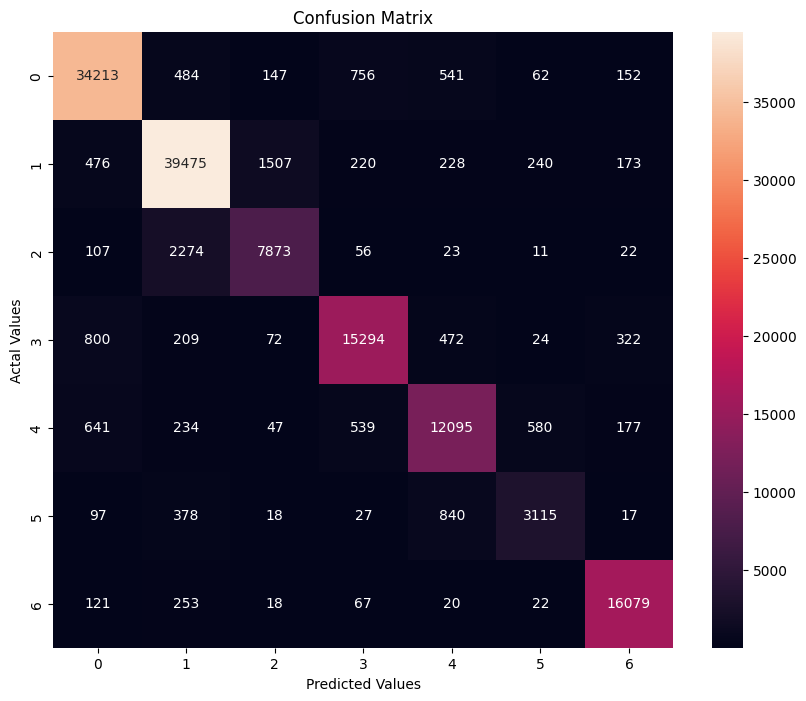

In [25]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [26]:
print(classification_report(ytest,ypred_lr_mn, digits=3))

              precision    recall  f1-score   support

           0      0.938     0.941     0.940     36355
           1      0.912     0.933     0.922     42319
           2      0.813     0.760     0.785     10366
           3      0.902     0.890     0.896     17193
           4      0.851     0.845     0.848     14313
           5      0.768     0.693     0.729      4492
           6      0.949     0.970     0.959     16580

    accuracy                          0.905    141618
   macro avg      0.876     0.862     0.868    141618
weighted avg      0.904     0.905     0.904    141618



In [27]:
pickle.dump(lr_mn, open('../models/lr_mn_emogoneutral.pkl', 'wb'))

In [28]:
weighting = compute_class_weight( class_weight ='balanced', classes =np.unique(y),y= y)
class_weights = dict(zip(np.unique(y), weighting))


In [29]:
lr_mn_cw = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weights)
lr_mn_cw.fit(Xtrain_tfidf, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5564877676147408, 1: 0.47805859143975177,
                                 2: 1.9516367755645407, 3: 1.1766826114159088,
                                 4: 1.4135038911496183, 5: 4.504198313041487,
                                 6: 1.2202453115508394},
                   multi_class='multinomial')

In [30]:
ypred_lr_mn_cw=lr_mn_cw.predict(Xtest_tfidf)

In [31]:
tr_acc_lr_mn_cw = lr_mn_cw.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn_cw =  accuracy_score(ytest,ypred_lr_mn_cw) * 100
print(tr_acc_lr_mn_cw,test_acc_lr_mn_cw)

91.44201670499939 90.4934400994224


In [32]:
print(classification_report(ytest,ypred_lr_mn_cw, digits=3))

              precision    recall  f1-score   support

           0      0.968     0.909     0.938     36355
           1      0.973     0.875     0.921     42319
           2      0.723     0.953     0.822     10366
           3      0.883     0.912     0.898     17193
           4      0.851     0.854     0.853     14313
           5      0.642     0.928     0.759      4492
           6      0.941     0.973     0.957     16580

    accuracy                          0.905    141618
   macro avg      0.854     0.915     0.878    141618
weighted avg      0.916     0.905     0.907    141618



In [33]:
pickle.dump(lr_mn_cw, open('../models/lr_mn_emogoneutral_cw.pkl', 'wb'))